In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sicapv2/SICAPv2/SICAPv2/readme.txt
/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0006669_Block_Region_24_6_2_xini_14275_yini_13598.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005230E_Block_Region_5_11_23_xini_38257_yini_96363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006621D_Block_Region_2_1_13_xini_21582_yini_66086.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006177A_Block_Region_2_6_19_xini_51693_yini_147491.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022612_Block_Region_1_20_12_xini_15667_yini_92428.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0035220_Block_Region_5_22_18_xini_39584_yini_76503.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022615_Block_Region_4_19_41_xini_44968_yini_22920.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0034247_Block_Region_2_21_7_xini_39052_yini_24363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005478I_Block_Region_2_1

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Paths
image_dir = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/images"
labels_path = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx"

# Load labels
df = pd.read_excel(labels_path)

# Map Gleason scores to GG labels
def gleason_to_gg(primary, secondary):
    total = primary + secondary
    if total == 7 and primary == 4:
        return "GG3"
    elif total == 8:
        return "GG4"
    elif total >= 9:
        return "GG5"
    else:
        return "NC"

df["GG"] = df.apply(lambda row: gleason_to_gg(row["Gleason_primary"], row["Gleason_secondary"]), axis=1)

# Preview
print(df.head())
print("Label Distribution:\n", df["GG"].value_counts())


     slide_id  patient_id  Gleason_primary  Gleason_secondary   GG
0  16B0001851      667360                4                  5  GG5
1  16B0003388      325687                4                  4  GG4
2  16B0003394      747184                3                  3   NC
3  16B0006668       14107                5                  5  GG5
4  16B0006669       14107                5                  5  GG5
Label Distribution:
 GG
NC     72
GG5    42
GG3    23
GG4    18
Name: count, dtype: int64


In [3]:
import glob

# Load all image paths
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
print("Total images found:", len(image_paths))

# Create patch-level dataframe
patch_data = []

# Create a dict from slide_id to GG label
slide_to_label = dict(zip(df["slide_id"], df["GG"]))

for path in image_paths:
    filename = os.path.basename(path)
    slide_id = filename.split("_")[0]
    
    if slide_id in slide_to_label:
        label = slide_to_label[slide_id]
        patch_data.append((path, label))

patch_df = pd.DataFrame(patch_data, columns=["path", "label"])
print("Total labeled patches:", len(patch_df))
print(patch_df["label"].value_counts())
patch_df.head()

Total images found: 18783
Total labeled patches: 18783
label
NC     7995
GG5    5654
GG3    3082
GG4    2052
Name: count, dtype: int64


,path,label
0,/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...,GG5
1,/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...,NC
2,/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...,GG3
3,/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...,GG5
4,/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...,NC


In [4]:
from sklearn.model_selection import train_test_split

# First split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    patch_df,
    test_size=0.2,
    stratify=patch_df["label"],
    random_state=42
)

# Then split temp into validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

# Confirm splits
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 15026
Validation: 1878
Test: 1879


In [5]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [7]:
from torch.utils.data import Dataset

# Label encoding: convert class names to numbers
label_to_index = {'NC': 0, 'GG3': 1, 'GG4': 2, 'GG5': 3}

class PatchDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = label_to_index[self.df.loc[idx, "label"]]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = PatchDataset(train_df, transform=train_transform)
val_dataset = PatchDataset(val_df, transform=val_transform)
test_dataset = PatchDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("✅ DataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

✅ DataLoaders created:
Train batches: 470
Val batches:   59
Test batches:  59


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained DenseNet201
model = models.densenet201(pretrained=True)

# Freeze earlier layers (optional)
for param in model.features.parameters():
    param.requires_grad = False

# Replace final classifier layer
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)  # 4 classes

# Move model to device
model = model.to(device)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 173MB/s]


In [10]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [11]:
import os
import torch

# Parameters
num_epochs = 10
best_acc = 0.0
checkpoint_dir = "checkpoints_densenet201"
os.makedirs(checkpoint_dir, exist_ok=True)

# Loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Update scheduler (if defined)
    if 'scheduler' in globals():
        scheduler.step(val_loss)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        model_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print("✅ Best model updated and saved.")

print(f"\n🏁 Training complete! Best Val Accuracy: {best_acc:.4f}")



Epoch 1/10
------------------------------
Train Loss: 1.1648 | Acc: 0.5249
Val Loss:   1.0782 | Acc: 0.5809
✅ Best model updated and saved.

Epoch 2/10
------------------------------
Train Loss: 1.0493 | Acc: 0.5839
Val Loss:   1.0189 | Acc: 0.5969
✅ Best model updated and saved.

Epoch 3/10
------------------------------
Train Loss: 1.0045 | Acc: 0.6026
Val Loss:   0.9888 | Acc: 0.6049
✅ Best model updated and saved.

Epoch 4/10
------------------------------
Train Loss: 0.9815 | Acc: 0.6063
Val Loss:   0.9693 | Acc: 0.6113
✅ Best model updated and saved.

Epoch 5/10
------------------------------
Train Loss: 0.9689 | Acc: 0.6130
Val Loss:   0.9609 | Acc: 0.6230
✅ Best model updated and saved.

Epoch 6/10
------------------------------
Train Loss: 0.9535 | Acc: 0.6201
Val Loss:   0.9543 | Acc: 0.6203

Epoch 7/10
------------------------------
Train Loss: 0.9387 | Acc: 0.6258
Val Loss:   0.9436 | Acc: 0.6235
✅ Best model updated and saved.

Epoch 8/10
------------------------------
Tr

In [16]:
from torch.optim.lr_scheduler import StepLR

# Scheduler: Decay LR by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)


In [17]:
# Continue training DenseNet-201 for 10 more epochs (Epochs 11 to 20)
import os

start_epoch = 10
num_additional_epochs = 10
total_epochs = start_epoch + num_additional_epochs

os.makedirs("checkpoints_densenet201", exist_ok=True)

for epoch in range(start_epoch, total_epochs):
    print(f"\nEpoch {epoch+1}/{total_epochs}")
    print("-" * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Update scheduler (if used)
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"checkpoints_densenet201/best_model_epoch_{epoch+1}.pth")
        print("✅ Best model updated and saved.")

print(f"\n🏁 Extended Training complete! Best Val Accuracy: {best_acc:.4f}")



Epoch 11/20
------------------------------
Train Loss: 0.8996 | Acc: 0.6453
Val Loss:   0.9124 | Acc: 0.6400

Epoch 12/20
------------------------------
Train Loss: 0.8967 | Acc: 0.6470
Val Loss:   0.9030 | Acc: 0.6459
✅ Best model updated and saved.

Epoch 13/20
------------------------------
Train Loss: 0.8941 | Acc: 0.6467
Val Loss:   0.9017 | Acc: 0.6496
✅ Best model updated and saved.

Epoch 14/20
------------------------------
Train Loss: 0.8876 | Acc: 0.6457
Val Loss:   0.8956 | Acc: 0.6518
✅ Best model updated and saved.

Epoch 15/20
------------------------------
Train Loss: 0.8873 | Acc: 0.6493
Val Loss:   0.8981 | Acc: 0.6448

Epoch 16/20
------------------------------
Train Loss: 0.8885 | Acc: 0.6445
Val Loss:   0.8970 | Acc: 0.6422

Epoch 17/20
------------------------------
Train Loss: 0.8858 | Acc: 0.6453
Val Loss:   0.8908 | Acc: 0.6523
✅ Best model updated and saved.

Epoch 18/20
------------------------------
Train Loss: 0.8834 | Acc: 0.6490
Val Loss:   0.8954 | Acc:

In [18]:
# Continue training DenseNet201 from Epoch 21 to 30
start_epoch = 20
num_additional_epochs = 10
total_epochs = start_epoch + num_additional_epochs

for epoch in range(start_epoch, total_epochs):
    print(f"\nEpoch {epoch+1}/{total_epochs}")
    print("-" * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"checkpoints_densenet201/best_model_epoch_{epoch+1}.pth")
        print("✅ Best model updated and saved.")

print(f"\n🏁 DenseNet201 Training (Epochs 21–30) complete! Best Val Accuracy so far: {best_acc:.4f}")



Epoch 21/30
------------------------------
Train Loss: 0.8756 | Acc: 0.6520
Val Loss:   0.8837 | Acc: 0.6507

Epoch 22/30
------------------------------
Train Loss: 0.8668 | Acc: 0.6601
Val Loss:   0.8845 | Acc: 0.6512

Epoch 23/30
------------------------------
Train Loss: 0.8749 | Acc: 0.6501
Val Loss:   0.8859 | Acc: 0.6507

Epoch 24/30
------------------------------
Train Loss: 0.8670 | Acc: 0.6569
Val Loss:   0.8897 | Acc: 0.6464

Epoch 25/30
------------------------------
Train Loss: 0.8618 | Acc: 0.6571
Val Loss:   0.8804 | Acc: 0.6581
✅ Best model updated and saved.

Epoch 26/30
------------------------------
Train Loss: 0.8723 | Acc: 0.6560
Val Loss:   0.8829 | Acc: 0.6518

Epoch 27/30
------------------------------
Train Loss: 0.8655 | Acc: 0.6620
Val Loss:   0.8793 | Acc: 0.6523

Epoch 28/30
------------------------------
Train Loss: 0.8614 | Acc: 0.6600
Val Loss:   0.8764 | Acc: 0.6565

Epoch 29/30
------------------------------
Train Loss: 0.8626 | Acc: 0.6603
Val Loss:  

In [19]:
# Train DenseNet201 from Epoch 31 to 40
start_epoch = 30
num_additional_epochs = 10
total_epochs = start_epoch + num_additional_epochs

for epoch in range(start_epoch, total_epochs):
    print(f"\nEpoch {epoch+1}/{total_epochs}")
    print("-" * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)  # only if using ReduceLROnPlateau

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"checkpoints_densenet201/best_model_epoch_{epoch+1}.pth")
        print("✅ Best model updated and saved.")

print(f"\n🏁 DenseNet201 Training Epochs 31–40 complete! Best Val Accuracy so far: {best_acc:.4f}")



Epoch 31/40
------------------------------
Train Loss: 0.8608 | Acc: 0.6623
Val Loss:   0.8744 | Acc: 0.6571

Epoch 32/40
------------------------------
Train Loss: 0.8535 | Acc: 0.6617
Val Loss:   0.8843 | Acc: 0.6470

Epoch 33/40
------------------------------
Train Loss: 0.8547 | Acc: 0.6634
Val Loss:   0.8784 | Acc: 0.6534

Epoch 34/40
------------------------------
Train Loss: 0.8541 | Acc: 0.6617
Val Loss:   0.8701 | Acc: 0.6592
✅ Best model updated and saved.

Epoch 35/40
------------------------------
Train Loss: 0.8533 | Acc: 0.6640
Val Loss:   0.8693 | Acc: 0.6571

Epoch 36/40
------------------------------
Train Loss: 0.8537 | Acc: 0.6608
Val Loss:   0.8783 | Acc: 0.6555

Epoch 37/40
------------------------------
Train Loss: 0.8532 | Acc: 0.6657
Val Loss:   0.8746 | Acc: 0.6523

Epoch 38/40
------------------------------
Train Loss: 0.8531 | Acc: 0.6625
Val Loss:   0.8703 | Acc: 0.6571

Epoch 39/40
------------------------------
Train Loss: 0.8534 | Acc: 0.6616
Val Loss:  

In [20]:
# Load best model for testing (DenseNet201)
best_model_path = "checkpoints_densenet201/best_model_epoch_34.pth"  # 🔁 Replace XX with best epoch number
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()
print("✅ Best DenseNet201 model loaded for testing.")


✅ Best DenseNet201 model loaded for testing.


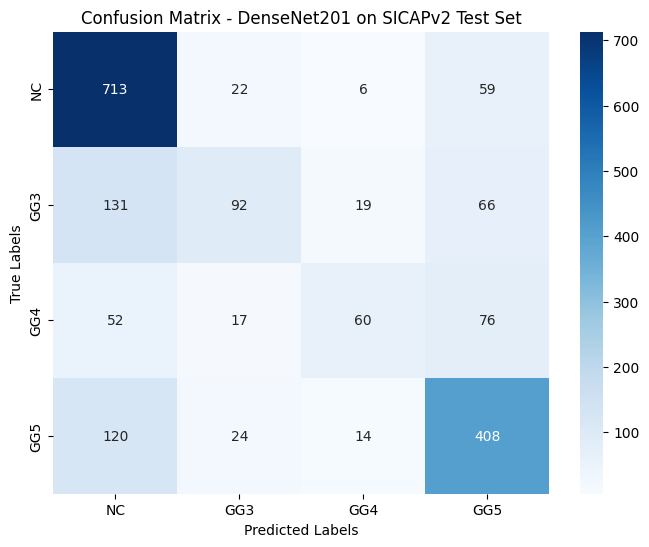

In [22]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define label names
label_names = ["NC", "GG3", "GG4", "GG5"]

# Ensure model is in eval mode
model.eval()

# Initialize
y_true = []
y_pred = []

# Run predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - DenseNet201 on SICAPv2 Test Set")
plt.show()


In [23]:
from sklearn.metrics import classification_report

# Define label names
label_names = ["NC", "GG3", "GG4", "GG5"]

# Collect predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
print("\n📊 Classification Report - DenseNet201 on SICAPv2 Test Set:")
print(classification_report(y_true, y_pred, target_names=label_names))



📊 Classification Report - DenseNet201 on SICAPv2 Test Set:
              precision    recall  f1-score   support

          NC       0.70      0.89      0.79       800
         GG3       0.59      0.30      0.40       308
         GG4       0.61      0.29      0.39       205
         GG5       0.67      0.72      0.69       566

    accuracy                           0.68      1879
   macro avg       0.64      0.55      0.57      1879
weighted avg       0.66      0.68      0.65      1879



In [24]:
import pandas as pd

# Save to CSV
test_results_df = pd.DataFrame({
    'TrueLabel': y_true,
    'PredictedLabel': y_pred
})

test_results_df.to_csv("densenet201_test_results.csv", index=False)
print("✅ Test results saved to densenet201_test_results.csv")


✅ Test results saved to densenet201_test_results.csv


🏅 ROC AUC Score (OVR): 0.8363


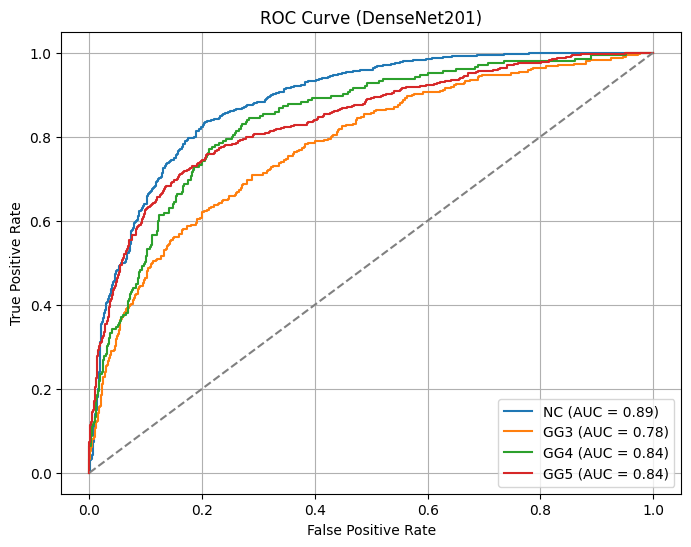

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define label names
label_names = ["NC", "GG3", "GG4", "GG5"]

# Convert labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])  # NC=0, GG3=1, GG4=2, GG5=3

# Get raw logits (probabilities before softmax)
y_probs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)

# AUC
auc = roc_auc_score(y_true_bin, y_probs, multi_class="ovr")
print(f"🏅 ROC AUC Score (OVR): {auc:.4f}")

# Plot ROC for each class
plt.figure(figsize=(8,6))
for i, label in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_true_bin[:, i], y_probs[:, i]):.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve (DenseNet201)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [26]:
# Save the DenseNet201 model state dictionary
torch.save(model.state_dict(), "densenet201_trained_sicapv2.pth")

print("✅ DenseNet201 model saved as densenet201_trained_sicapv2.pth")


✅ DenseNet201 model saved as densenet201_trained_sicapv2.pth
